# 教程：Hebbian学习的模式存储和回忆

> **阅读时间**：约30-35分钟
> **难度**：中级
> **前置要求**：对神经网络和Python的基本理解

本教程通过Hebbian可塑性和使用Hopfield网络的联想记忆介绍脑启发学习。

---

## 目录

1. [Hebbian学习介绍](#1-introduction-to-hebbian-learning)
2. [用于联想记忆的Hopfield网络](#2-hopfield-networks-for-associative-memory)
3. [完整示例：MNIST数字记忆](#3-complete-example-mnist-digit-memory)
4. [反Hebbian学习](#4-anti-hebbian-learning)
5. [后续步骤](#5-next-steps)

---

## 1. Hebbian Learning 简介

### 1.1 Hebbian Learning 原理

**"一起放电的神经元，会一起连接"**

Hebbian Learning 是一种受生物启发的学习规则，当前突触神经元和后突触神经元同时活跃时，突触强度会增加：

$$
\Delta W_{ij} = \eta \cdot x_i \cdot x_j
$$

其中：
- $W_{ij}$：从神经元i到神经元j的突触权重
- $\eta$：学习率
- $x_i, x_j$：神经元i和j的活动

### 1.2 为什么使用Hebbian Learning？

**生物学真实性**：
- 局部学习规则（无需全局误差信号）
- 活动依赖的可塑性
- 与皮层实验观察相符

**计算优势**：
- 无监督学习
- 模式完成和噪声抗干扰
- 用于记忆的吸引子动力学

### 1.3 Amari Hopfield网络中的Hebbian Learning

In [ ]:
from canns.models.brain_inspired import AmariHopfieldNetwork
from canns.trainer import HebbianTrainer

# 创建网络
model = AmariHopfieldNetwork(num_neurons=784)  # 28x28 图像

# 使用Hebbian学习创建训练器
trainer = HebbianTrainer(model, compiled_prediction=True)

# 在模式上训练
trainer.train(pattern_list)

# 从损坏的输入检索
output = trainer.predict(noisy_pattern)

---

## 2. 用于联想记忆的Amari Hopfield网络

### 2.1 什么是Amari Hopfield网络？

**Amari Hopfield网络**是一种递归神经网络，它在能量景观中将模式存储为稳定吸引子：

- **存储**：Hebbian学习在训练模式处创建吸引子
- **检索**：网络动力学收敛到最近的存储模式
- **容量**：可以存储大约 $0.138 \times N$ 个模式（$N$ = 神经元数量）

### 2.2 网络动力学

Amari Hopfield网络更新其状态以最小化能量：

$$
E = -\frac{1}{2} \sum_{i,j} W_{ij} \cdot x_i \cdot x_j
$$

**更新规则**：
- **异步**：一次更新一个神经元
- **同步**：同时更新所有神经元

In [ ]:
from canns.models.brain_inspired import AmariHopfieldNetwork

# 离散激活函数（符号函数）：x ∈ {-1, +1}
model = AmariHopfieldNetwork(
    num_neurons=784,
    threshold=80.0,      # 收敛阈值
    asyn=False,          # 同步更新
    activation="sign"    # 二进制状态 {-1, +1}
)

### 2.3 关键参数

| 参数 | 类型 | 描述 |
|-----------|------|-------------|
| `num_neurons` | int | 网络大小（例如，28×28 图像为 784） |
| `threshold` | float | 收敛准则（最大迭代次数） |
| `asyn` | bool | 异步（True）或同步（False）更新 |
| `activation` | str | "sign"（离散）或 "tanh"/"sigmoid"（连续） |

---

## 3. 完整示例：MNIST 数字记忆

### 3.1 设置和数据加载

In [1]:
import numpy as np
from canns.models.brain_inspired import AmariHopfieldNetwork
from canns.trainer import HebbianTrainer

# 加载MNIST数据（自动尝试多个源）
def load_mnist_data():
    """使用可用库加载MNIST（datasets/torchvision/keras/sklearn）"""
    try:
        from datasets import load_dataset
        ds_train = load_dataset("mnist", split="train")
        x_train = np.stack([np.array(img, dtype=np.float32) for img in ds_train["image"]])
        y_train = np.array(ds_train["label"], dtype=np.int64)
        return x_train, y_train
    except:
        # 回退到其他源...
        from torchvision.datasets import MNIST
        ds_train = MNIST(root="~/.cache/torchvision", train=True, download=True)
        x_train = ds_train.data.numpy().astype(np.float32)
        y_train = ds_train.targets.numpy().astype(np.int64)
        return x_train, y_train

x_train, y_train = load_mnist_data()
print(f"已加载{len(x_train)}张训练图像")

README.md: 0.00B [00:00, ?B/s]

mnist/train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

mnist/test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Loaded 60000 training images


### 3.2 数据预处理

Amari Hopfield网络最适合处理二进制模式 {-1, +1}：

In [2]:
def threshold_to_binary(image, use_mean=True):
    """将灰度图像转换为 {-1, +1}"""
    if use_mean:
        threshold = image.mean()
    else:
        from skimage.filters import threshold_mean
        threshold = threshold_mean(image)

    binary = image > threshold
    return np.where(binary, 1.0, -1.0).astype(np.float32)

def flatten_image(image_2d):
    """将2D图像展平为1D向量"""
    return image_2d.reshape(-1)

# 选择要存储的模式（例如，数字 0, 1, 2）
classes = [0, 1, 2]

# 每个类获取一个训练样本
train_patterns = []
for digit in classes:
    # 找到该数字的第一个出现
    idx = np.where(y_train == digit)[0][0]
    img_2d = x_train[idx]

    # 转换为二进制并展平
    binary = threshold_to_binary(img_2d)
    flat = flatten_image(binary)
    train_patterns.append(flat)

print(f"准备了 {len(train_patterns)} 个训练模式")
print(f"模式维度: {train_patterns[0].shape}")

Prepared 3 training patterns
Pattern dimensions: (784,)


### 3.3 创建和训练Amari Hopfield网络

In [3]:
# 创建Hopfield网络
n_neurons = train_patterns[0].size  # 784用于28×28图像
model = AmariHopfieldNetwork(
    num_neurons=n_neurons,
    threshold=80.0,        # 收敛的最大迭代次数
    asyn=False,            # 同步更新
    activation="sign"      # 二值激活
)

# 创建Hebbian训练器
trainer = HebbianTrainer(
    model,
    compiled_prediction=True  # 使用JIT编译以提高速度
)

# 在模式上训练（一次性学习！）
print("正在训练网络...")
trainer.train(train_patterns)
print("训练完成！")

Training network...
Training complete!


**训练细节**:
- **单次学习**: 模式在单次传递中存储
- **权重更新**: $W = \frac{1}{P} \sum_{\mu} \mathbf{p}_\mu \mathbf{p}_\mu^T$ (归一化Hebbian规则)
- **对角线清零**: $W_{ii} = 0$ (无自连接)
- **均值减法**: 可选，用于改进存储

### 3.4 模式检索

测试网络检索存储模式的能力:

In [4]:
# 获取测试模式（同一数字的不同示例）
test_patterns = []
for digit in classes:
    # 找到第二次出现（与训练数据不同）
    idx = np.where(y_train == digit)[0][1]
    img_2d = x_train[idx]
    binary = threshold_to_binary(img_2d)
    flat = flatten_image(binary)
    test_patterns.append(flat)

# 检索模式
print("正在检索模式...")
retrieved = trainer.predict_batch(
    test_patterns,
    show_sample_progress=True  # 显示收敛进度
)

print(f"检索了 {len(retrieved)} 个模式")

Retrieving patterns...


Processing samples: 100%|█████████████| 3/3 [00:00<00:00,  6.89it/s, sample=3/3]

Retrieved 3 patterns


### 3.5 可视化

比较训练、输入和检索的模式：

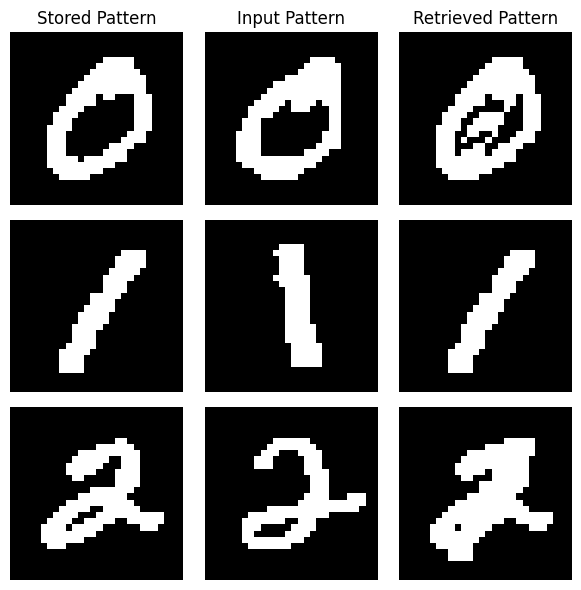

In [5]:
import matplotlib.pyplot as plt

def reshape_to_image(flat_vector):
    """将1D向量重塑为2D图像"""
    dim = int(np.sqrt(flat_vector.size))
    return flat_vector.reshape(dim, dim)

# 创建可视化
fig, axes = plt.subplots(len(classes), 3, figsize=(6, 2*len(classes)))

for i in range(len(classes)):
    # 训练模式
    axes[i, 0].imshow(reshape_to_image(train_patterns[i]), cmap='gray')
    axes[i, 0].axis('off')
    if i == 0:
        axes[i, 0].set_title('存储的模式')

    # 测试输入
    axes[i, 1].imshow(reshape_to_image(test_patterns[i]), cmap='gray')
    axes[i, 1].axis('off')
    if i == 0:
        axes[i, 1].set_title('输入模式')

    # 检索到的模式
    axes[i, 2].imshow(reshape_to_image(retrieved[i]), cmap='gray')
    axes[i, 2].axis('off')
    if i == 0:
        axes[i, 2].set_title('检索到的模式')

plt.tight_layout()
plt.savefig('hopfield_mnist_retrieval.png', dpi=150)
plt.show()

**预期结果**：
- 检索的模式与存储的模式紧密匹配
- 网络能够完成模式，即使输入存在差异
- 可能存在一些失真（取决于模式相似度）

### 3.6 噪声测试

添加噪声以测试鲁棒性：

In [6]:
def add_noise(pattern, noise_level=0.1):
    """以给定概率随机翻转比特位"""
    noise_mask = np.random.random(pattern.shape) < noise_level
    noisy = pattern.copy()
    noisy[noise_mask] *= -1  # 翻转符号
    return noisy

# 使用噪声输入进行测试
noise_levels = [0.0, 0.1, 0.2, 0.3]

for noise in noise_levels:
    print(f"\n使用 {int(noise*100)}% 噪声进行测试:")
    noisy_inputs = [add_noise(p, noise) for p in test_patterns]
    recovered = trainer.predict_batch(noisy_inputs)

    # 计算准确率（正确比特位的比例）
    accuracies = []
    for orig, recov in zip(train_patterns, recovered):
        accuracy = np.mean(orig == recov)
        accuracies.append(accuracy)

    print(f"  平均准确率: {np.mean(accuracies):.2%}")


Testing with 0% noise:


Processing samples: 100%|█████████████| 3/3 [00:00<00:00, 15.25it/s, sample=3/3]


  Mean accuracy: 97.07%

Testing with 10% noise:


Processing samples: 100%|█████████████| 3/3 [00:00<00:00, 15.36it/s, sample=3/3]


  Mean accuracy: 97.07%

Testing with 20% noise:


Processing samples: 100%|█████████████| 3/3 [00:00<00:00, 16.99it/s, sample=3/3]


  Mean accuracy: 97.07%

Testing with 30% noise:


Processing samples: 100%|█████████████| 3/3 [00:00<00:00, 15.49it/s, sample=3/3]

  Mean accuracy: 88.95%


**观察结果**：
- 低噪声（< 20%）：接近完美的检索
- 中等噪声（20-30%）：性能下降但仍可识别
- 高噪声（> 40%）：可能收敛到错误的模式

---

## 4. 后续步骤

恭喜！您已学会了具有赫布可塑性和联想记忆的脑启发学习基础知识。

### 关键要点

1. **赫布学习**是局部的、无监督的且生物学上真实的
2. **霍普菲尔德网络**将模式存储为能量最小值
3. **一次性学习**可通过赫布规则实现
4. **模式补全**适用于部分/噪声输入

### 何时使用赫布学习

- **联想记忆**：存储和检索模式
- **无监督学习**：不需要标签
- **一次性学习**：从少数示例中学习
- **模式补全**：对噪声和缺失数据具有鲁棒性
- **生物建模**：匹配神经可塑性

### 局限性

- **容量限制**：对于 $N$ 个神经元，约 $0.138 \times N$ 个模式
- **虚假吸引子**：网络可能收敛到不期望的状态
- **无错误最小化**：与反向传播不同
- **二进制模式**：最适用于 $\{-1, +1\}$ 状态

### 相关模型

这些脑启发模型可在 CANNs 库中获得：
- `AmariHopfieldNetwork` - 模式存储和联想记忆
- `LinearLayer` - 具有赫布学习的通用前馈层
- `SpikingLayer` - 用于 STDP 的漏积分-发火神经元

有关更多详情，请参阅 [API 文档](../../api_reference.ipynb) 或浏览 `canns.models.brain_inspired` 和 `canns.trainer`。